# Visualisation of the Prediction Depth of CIFAR-10

### - Read output from `get_pd`

In [8]:
import os
import json

def read_avg_files(directory: str, train=True):
    """
    This function reads the avg.json file from the directory
    :param directory:
    :param train: True if we wants train_avg.json, False if we wants test_avg.json
    :return:
    """
    file_list = os.listdir(directory)
    if train:
        json_files = [file for file in file_list if file.endswith("train_avg.json")]
    else:
        json_files = [file for file in file_list if file.endswith("test_avg.json")]

    if len(json_files) == 0:
        raise FileNotFoundError("No {}avg.json file found in the directory".format("train" if train else "test"))
    elif len(json_files) > 1:
        raise FileExistsError("More than one {}avg.json file found in the directory".format("train" if train else "test"))
    else:
        with open(os.path.join(directory, json_files[0]), "r") as f:
            avg_dict = json.load(f)

    return avg_dict


il_dict_train = read_avg_files(os.path.join(os.getcwd(), "il_results", "avg"), train=True)
il_dict_test = read_avg_files(os.path.join(os.getcwd(), "il_results", "avg"), train=False)

### - Link `il_dict` to `cifar10` dataset

In [9]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor
import matplotlib.pyplot as plt

class CIFAR10PD(CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CIFAR10PD, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, index):
        # to get (img, target), index
        img, target = super(CIFAR10PD, self).__getitem__(index)
        return PILToTensor()(img), target, index
trainset = CIFAR10PD('./', train=False, download=True)
testset = CIFAR10PD('./', train=True, download=True)

dataloader_train = DataLoader(trainset, batch_size=1, shuffle=False)
dataloader_test = DataLoader(testset, batch_size=1, shuffle=False)

CIFAR_dict_train = {}
CIFAR_dict_test = {}

for imgs, targets, indexes in dataloader_train:
    for img, target, index in zip(imgs, targets, indexes):
        CIFAR_dict_train[index.item()] = (img, target)

for imgs, targets, indexes in dataloader_test:
    for img, target, index in zip(imgs, targets, indexes):
        CIFAR_dict_test[index.item()] = (img, target)

Files already downloaded and verified
Files already downloaded and verified


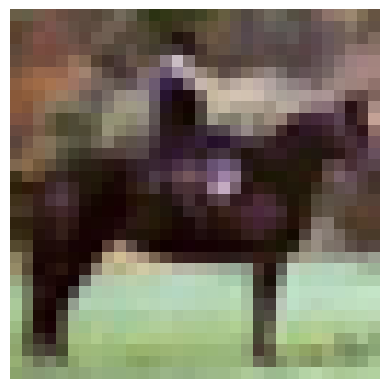

In [10]:
image_np = CIFAR_dict_train[1198][0].numpy()
image_np = image_np.transpose(1, 2, 0)

# Plot the CIFAR-10 image
plt.imshow(image_np)
plt.axis('off')
plt.show()

### - split the unlearned images and learned images

In [11]:
learned_il_dict_train = {}
unlearned_il_dict_train = {}
learned_il_dict_test = {}
unlearned_il_dict_test = {}

for index, score in il_dict_train.items():
    if score == -1:
        learned_il_dict_train[index] = -1
    else:
        learned_il_dict_train[index] = score

for index, score in il_dict_test.items():
    if score == -1:
        learned_il_dict_test[index] = -1
    else:
        learned_il_dict_test[index] = score

def imgHardnessLink(img_dict: dict, hardness_dict:dict) -> dict:
    """
    This function gives each image its hardness score
    @param img_dict: dictionary of image in the format of {index : (img, target)}
    @param pd_dict: dictionary of image in the format of {index : PD score}
    @return: dictionary of {img : (target, PD score)}
    """

    # type checking to make sure the key is int
    type_check = [type(k) for k in img_dict.keys()]
    if not all([t == int for t in type_check]):
        new_dict = {}
        for k, v in img_dict.items():
            new_dict[int(k)] = v
        img_dict = new_dict

    type_check = [type(k) for k in hardness_dict.keys()]
    if not all([t == int for t in type_check]):
        new_dict = {}
        for k, v in hardness_dict.items():
            new_dict[int(k)] = v
        hardness_dict = new_dict

    img_hardness_dict = {}
    for index in (set(hardness_dict.keys()).intersection(set(img_dict.keys()))):
        img_hardness_dict[img_dict[index][0]] = (img_dict[index][1], hardness_dict[index], index)
    return img_hardness_dict


learned_img_IL_dict_train = imgHardnessLink(CIFAR_dict_train, learned_il_dict_train)
unlearned_il_dict_train = imgHardnessLink(CIFAR_dict_train, unlearned_il_dict_train)
learned_img_IL_dict_test = imgHardnessLink(CIFAR_dict_test, learned_il_dict_test)
unlearned_il_dict_test = imgHardnessLink(CIFAR_dict_test, unlearned_il_dict_test)

### -Visualisation (trainset)

In [ ]:
# Visualisation of the iteration learned of CIFAR-10, we grab 10 images for each score after scaled
scaled_img_IL_dict_train = {}
for key, (img, score, index) in learned_img_IL_dict_train.items():
    scaled_img_IL_dict_train[key] = (img, round(score/20), index)
max_score = max([score for (_, score, _) in scaled_img_IL_dict_train.values()])
min_score = min([score for (_, score, _) in scaled_img_IL_dict_train.values()])
images_per_score = [[] for _ in range(max_score + 1)]
for img, (target, score, index) in scaled_img_IL_dict_train.items():
    images_per_score[score].append((img, target, index)) if len(images_per_score[score]) < 10 else None

target_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for score, images in enumerate(images_per_score):
    if len(images) == 0:
        continue
    print(f"Score: {score+1}")
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for i, (img, target, index) in enumerate(images):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(target_names[target])
        axes[i].axis('off')
    plt.show()

In [13]:
# plotting 10 never learned images in unlearned_il_dict
if len(unlearned_il_dict_train) < 10:
    print("There are less than 10 unlearned images")
else:
    ten_unlearned_images = list(unlearned_il_dict_train.items())[:10]
    fig, axes = plt.subplots(1, len(ten_unlearned_images), figsize=(20, 20))
    for i, (img, (target, score, index)) in enumerate(ten_unlearned_images):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(target_names[target])
        axes[i].axis('off')
    plt.show()

There are less than 10 unlearned images


# Compare Iteration Learned with Prediction Depth (train set)

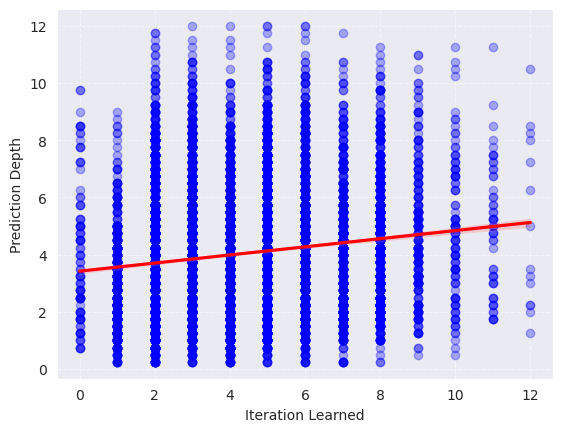

In [19]:
import seaborn as sns

pd_avg_dict_train = read_avg_files('./pd_results/avg', train=True)

imgPD_dict = imgHardnessLink(CIFAR_dict_train, pd_avg_dict_train)
imgIL_dict = imgHardnessLink(CIFAR_dict_train, il_dict_train)

# relabel all -1 (unlearned) example to 10
il_dict_all = {}
for key, (img, score, index) in imgIL_dict.items():
    if score == -1:
        il_dict_all[key] = (img, 10, index)
    else:
        il_dict_all[key] = (img, round(score/20), index) # divide 20 because we know the max score is 80

common_keys = set(imgPD_dict.keys()).intersection(il_dict_all.keys())

score_il = []
score_pd = []
for key in common_keys:
    score_il.append(il_dict_all[key][1])
    score_pd.append(imgPD_dict[key][1])

sns.regplot(x=score_il, y=score_pd, scatter_kws={"color": "blue", "alpha": 0.3}, line_kws={"color": "red"})
plt.xlabel("Iteration Learned")
plt.ylabel("Prediction Depth")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Compare Iteration Learned with Prediction Depth (train set)

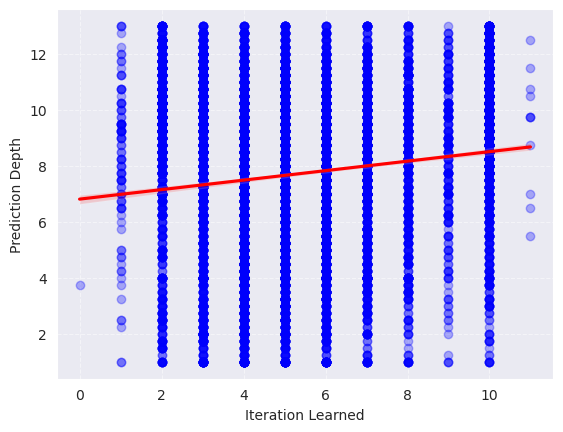

In [20]:
pd_avg_dict_test = read_avg_files('./pd_results/avg', train=False)

imgPD_dict = imgHardnessLink(CIFAR_dict_test, pd_avg_dict_test)
imgIL_dict = imgHardnessLink(CIFAR_dict_test, il_dict_test)

# relabel all -1 (unlearned) example to 10
il_dict_all = {}
for key, (img, score, index) in imgIL_dict.items():
    if score == -1:
        il_dict_all[key] = (img, 10, index)
    else:
        il_dict_all[key] = (img, round(score/20), index) # divide 20 because we know the max score is 80

common_keys = set(imgPD_dict.keys()).intersection(il_dict_all.keys())

score_il = []
score_pd = []
for key in common_keys:
    score_il.append(il_dict_all[key][1])
    score_pd.append(imgPD_dict[key][1])

sns.regplot(x=score_il, y=score_pd, scatter_kws={"color": "blue", "alpha": 0.3}, line_kws={"color": "red"})
plt.xlabel("Iteration Learned")
plt.ylabel("Prediction Depth")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()